In [8]:
# Imports
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve, validation_curve, GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [2]:
# Import change_summary
changelog = pd.read_csv('../Changelogs/change_summary.csv').to_dict(orient='records')

# Change summary intialization and check
change_summary = pd.DataFrame(changelog)
pd.set_option('display.max_colwidth', None)
display(change_summary)  

,column,change,rationale
0,age,Removed 3 row(s) where age > 125,Oldest verified human lived to be 122; values above 125 are likely errors or outliers.
1,loan_status,Dropped loan_status column,Target variable for classification; not needed in cleaned dataset.
2,person_income,"Capped person_income at $3,000,000 and applied log1p transformation",Handled extreme right skew and outliers in income distribution; log1p applied to normalize values and removed person_income for modeling.
3,loan_amnt,Applied log1p transformation to loan_amount,Handled extreme right skew and outliers in loan amount distribution; log1p applied to normalize values.
4,person_emp_exp,Removed 5 row(s) where person_emp_exp > 70,Unrealistic employment experience; values above 70 years are likely errors or outliers.
5,person_education,Combined Master and Doctorate categories into one group -- Graduate,Doctorate had the lowest frequency out of all the categories which could impact analysis
6,person_home_ownership,Combined RENT and OTHER into Non-Homeowner category and MORTGAGE and OWN into Homeowner category,RENT and MORTGAGE had high frequencies while OWN and OTHER had low frequencies which could impact analysis
7,"['person_gender', 'loan_intent', 'previous_loan_defaults_on_file', 'person_education_new', 'person_home_ownership_new']",Applied one-hot encoding (drop_first=True),Converted categorical variables into binary indicators for model compatibility.
8,loan_status,Readded loan_status column,Target variable for classification; readded after cleaning and preprocessing.


In [3]:
# Load cleaned data from CSV
df = pd.read_csv("../Data/cleaned_loan_data.csv")
df.head()

,person_age,person_emp_exp,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,log_income,log_loan_amt,person_gender_male,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,previous_loan_defaults_on_file_Yes,person_education_new_Bachelor,person_education_new_Graduate,person_education_new_High School,person_home_ownership_new_Non-Homeowner,loan_status
0,22,0,16.02,0.49,3,561,11.183713,10.463132,0,0,0,0,1,0,0,0,1,0,1,1
1,21,0,11.14,0.08,2,504,9.415971,6.908755,0,1,0,0,0,0,1,0,0,1,0,0
2,25,3,12.87,0.44,3,635,9.428592,8.612685,0,0,0,1,0,0,0,0,0,1,0,1
3,23,0,15.23,0.44,2,675,11.286702,10.463132,0,0,0,1,0,0,0,1,0,0,1,1
4,24,1,14.27,0.53,4,586,11.099469,10.463132,1,0,0,1,0,0,0,0,1,0,1,1


In [4]:
# Split the data into features and target variable
X = df.drop(columns=['loan_status'])
y = df['loan_status']

<h3> Split the data into training and testing sets </h3>

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

X_train: (31494, 19)
X_test: (13498, 19)


In [6]:
# Scale the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Check for class imbalance
print(f"Class distribution in training set:\n{y_train.value_counts(normalize=True)}")
print(f"Class distribution in test set:\n{y_test.value_counts(normalize=True)}")

# Changelog addition
changelog.append({
    'column': 'numerical_columns',
    'change': 'Applied MinMaxScaler to training data; transformed test data using same scaler.',
    'rationale': 'Avoided data leakage by fitting scaler only on training data. Ensures proper model generalization and adheres to machine learning best practices.'
})


Class distribution in training set:
loan_status
0    0.777799
1    0.222201
Name: proportion, dtype: float64
Class distribution in test set:
loan_status
0    0.777819
1    0.222181
Name: proportion, dtype: float64


<h3> Use SMOTE to handle the class imbalance in the data </h3>

In [7]:
# SMOTE for handling class imbalance
smote = SMOTE(random_state=42)
X_smote_train, y_smote_train = smote.fit_resample(X_train, y_train)

# Check the class distribution after SMOTE
X_smote_test = X_test
y_smote_test = y_test

# Changelog entry for SMOTE
changelog.append({
    'column': 'subscribe_to_term_deposit',
    'change': f'Resampled training set with SMOTE (train shape now: {X_smote_train.shape}, test shape: {X_test.shape})',
    'rationale': 'Used SMOTE to correct class imbalance in training data for better model performance.'
})


<h3> Model: XGBoost </h3>

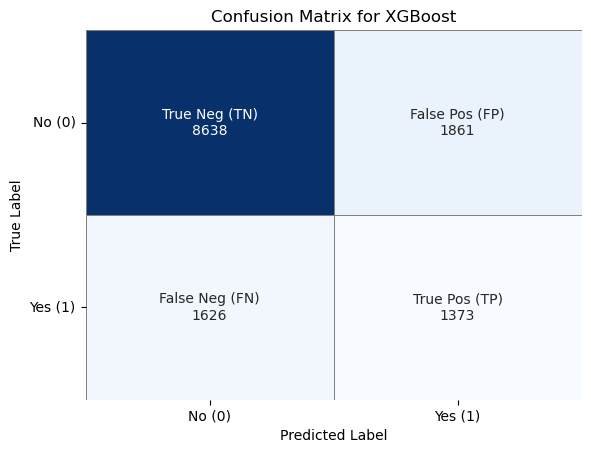

Accuracy Score: 0.74
Precision Score: 0.42
Recall Score: 0.46
Specificity Score: 0.82


In [11]:
#Initialize the model
xgbc = xgb.XGBClassifier(objective='binary:logistic',
                      n_estimators=100, 
                      learning_rate=0.1, 
                      max_depth=3, 
                      random_state=42)

#Train the model
xgbc.fit(X_smote_train, y_smote_train)

#Make predictions
y_pred = xgbc.predict(X_test)

#Create correlation matrix
cm = confusion_matrix(y_test, y_pred)

# Define labels for annotations
group_names = ['True Neg (TN)', 'False Pos (FP)', 'False Neg (FN)', 'True Pos (TP)']
group_counts = [f'{value}' for value in cm.flatten()]
labels = [f'{name}\n{count}' for name, count in zip(group_names, group_counts)]
labels = np.array(labels).reshape(2, 2)


sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False, linewidths=0.5, linecolor='gray')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for XGBoost')
plt.xticks(ticks=[0.5, 1.5], labels=['No (0)', 'Yes (1)'])
plt.yticks(ticks=[0.5, 1.5], labels=['No (0)', 'Yes (1)'], rotation=0)
plt.show()

#Evaluate the model
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_smote_test, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_smote_test, y_pred)))
print('Recall Score: {:.2f}'.format(recall_score(y_smote_test, y_pred)))

tn = cm[0,0]
fp = cm[0,1]
specificity = tn/(tn+fp)
print('Specificity Score: {:.2f}'.format(specificity))


<h3> Feature Importance </h3>

In [12]:
feature_importance = pd.DataFrame ({
    'feature': X_train.columns,
    'importance': xgbc.feature_importances_
})

feature_importance = feature_importance.sort_values(by='importance', ascending=False)
print(feature_importance)

                                    feature  importance
14       previous_loan_defaults_on_file_Yes    0.246611
15            person_education_new_Bachelor    0.103324
9                     loan_intent_EDUCATION    0.087545
13                      loan_intent_VENTURE    0.068503
12                     loan_intent_PERSONAL    0.068155
10              loan_intent_HOMEIMPROVEMENT    0.064224
16            person_education_new_Graduate    0.063879
17         person_education_new_High School    0.062160
11                      loan_intent_MEDICAL    0.057282
8                        person_gender_male    0.048174
3                       loan_percent_income    0.045955
18  person_home_ownership_new_Non-Homeowner    0.029168
4                cb_person_cred_hist_length    0.012615
2                             loan_int_rate    0.010512
7                              log_loan_amt    0.009294
0                                person_age    0.008369
6                                log_income    0